# HODEmu

Here below we will see a very short tutorial on how to use the satellie HOD cosmology emulator presented in Ragagnin et al. 2021.

First we will se how obtain satellite HOD parameters (i.e. normalisation, log-slope and log-scatter from Eq.), then how to produce Ns-M relation and then how to produce a mock satellite abundance Ns.

To run this notebook you need hod_emu.py and from _hod_emu_sklearn_gpr_serialized.py https://github.com/aragagnin/HODEmu

## Import of libraries

We import the emulator `hod_emu`. You can obtain it by downloading `hod_emu.py` from the github, or with the following
command:

```bash
python -mpip install  git+https://github.com/aragagnin/g3read
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hod_emu

## Get satellite HOD data


First we need to obtain the emulator by calling either `get_emulator_mvir()` or `get_emulator_m200c()` depending if we need $N_{s,\tt{vir}}$ or $N_{s,\tt{200c}}.$

To obtain satellite HOD parameters we can call function `predict_A_beta_sigma([[Omega_m, Omega_b, sigma8, h0, scale_factor]])` which requirest an array of datapoints as input, each with parameters $(\Omega_m, \Omega_b, \sigma_8, h_0, 1/(1+z)).$

The resulting parametrs are $A, \beta, \sigma$ presented in Equations 4 and 5, so that the satellite abundance $N_s$ is  

$$N_s(M) = A(\frac{M}{M_p})^\beta$$

and $\sigma$ is the log scatter and the pivot mass is $M_p=5\cdot10^{14}M_\odot$ for  both $\Delta_\tt{vir}$ and $\Delta_\tt{200c}.$

Note that the satellite abundance has been trained to return satellite count with stellar mass $M_\star>2\cdot10^{11}M_\odot.$  To rescale this value to a lower cut, use Eq. 3 in the paper.

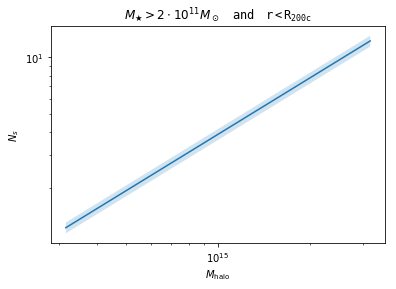

In [2]:
Om0 = 0.3
Ob0 = 0.04
s8 = 0.8
h0 = 0.7
z = 0.8

input = [[Om0, Ob0, s8, h0, 1./(1.+z)]] #the input must be a 2d array because you can feed an array of data points

emu = hod_emu.get_emulator_m200c() # use get_emulator_mvir to obtain the emulator within Delta_vir

A, beta, sigma  =  emu.predict_A_beta_sigma(input).T

masses = np.logspace(14.5,15.5,20)

Ns = A*(masses/5e14)**beta


plt.plot(masses,Ns)
plt.fill_between(masses, Ns*(1.-sigma), Ns*(1.+sigma),alpha=0.2)
plt.xlabel(r'$M_{\rm{halo}}$')
plt.ylabel(r'$N_s$')
plt.title(r'$M_\bigstar>2\cdot10^{11}M_\odot \ \ \ \tt{ and }  \ \ \ \ \  r<R_{\tt{200c}}$')
plt.xscale('log')
plt.yscale('log')


## Get Emulator standard deviation

The Gaussian Process Regression emulator provides itself an estimate of the standard deviation. You can request it by calling `predict_A_beta_sigma(..., emulator_std=True)`. The function will then returns a tuple to values (1) the A,\beta,sigma value as before and (2) a numpy array of the same shape as the first point but containing standard deviations of $ln(A), ln(\beta)$ and $ln(\sigma).$


In [3]:
params_tuple, stds_tuple  =  emu.predict_A_beta_sigma(input, emulator_std=True)

A, beta, sigma = params_tuple.T
error_logA, error_logbeta, error_logsigma = stds_tuple.T

print('A: %.3e, log-std A: %.3e'%(A[0], error_logA[0]))
print('B: %.3e, log-std beta: %.3e'%(beta[0], error_logbeta[0]))
print('sigma: %.3e, log-std sigma: %.3e'%(sigma[0], error_logsigma[0]))

A: 1.933e+00, log-std A: 1.242e-01
B: 1.002e+00, log-std beta: 8.275e-02
sigma: 6.723e-02, log-std sigma: 2.128e-01


## Emulate mock data

To emulate both haloes and their satellite number we use the package `import hmf.helpers.sample`
 from https://hmf.readthedocs.io/en/latest/
 
Note that our likelihood (Eq. 4) imposes a Gaussian distribution with a cut on negative values, hence the function `non_neg_normal_sample`

no camb


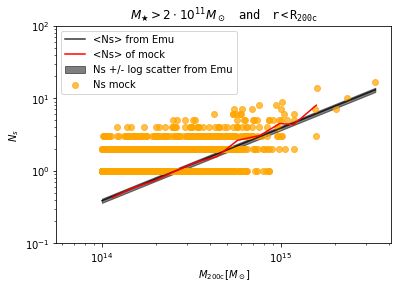

In [4]:
import hmf.helpers.sample
import scipy.stats

masses = hmf.helpers.sample.sample_mf(4000,14.0,hmf_model="PS",Mmax=17,sort=True)[0]    
    
def non_neg_normal_sample(loc, scale,  max_iters=1000):
    "Given a numpy-array of loc and scale, return data from only-positive normal distribution."
    vals = scipy.stats.norm.rvs(loc = loc, scale=scale)
    mask_negative = vals<0.
    if(np.any(vals[mask_negative])):
        non_neg_normal_sample(loc[mask_negative], scale[mask_negative],  max_iters=1000)
    # after the recursion, we should have all positive numbers
    mask_negative = vals<0.
    if(np.any(vals[mask_negative])):
        raise Exception("non_neg_normal_sample function failed to provide  positive-normal")    
    return vals

A, beta, logscatter = emu.predict_A_beta_sigma( [Om0, Ob0, s8, h0, 1./(1.+z)])[0].T

Ns = A*(masses/5e14)**beta

modelmu = non_neg_normal_sample(loc = Ns, scale=logscatter*Ns)
modelpois = scipy.stats.poisson.rvs(modelmu)
modelmock = modelpois

bins = np.logspace( 14.,15.3,12)
h_nsat, h_b = np.histogram(masses, weights=modelmock, bins=bins)
h_nele, h_b = np.histogram(masses, bins=bins)
h_nmass, h_b = np.histogram(masses, weights=masses, bins=bins)
h_x = h_nmass/h_nele
h_y = h_nsat/h_nele

plt.fill_between(masses, Ns *(1.-logscatter), Ns *(1.+logscatter), label='Ns +/- log scatter from Emu', color='black',alpha=0.5)
plt.scatter(masses, modelmock , label='Ns mock', color='orange',alpha=0.7)
plt.plot(masses, Ns , label='<Ns> from Emu', color='black',alpha=0.8)
plt.plot(h_x, h_y , label='<Ns> of mock', color='red')
plt.ylim([0.1,100.])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm {200c}} [M_\odot]$')
plt.ylabel(r'$N_s$')
plt.title(r'$M_\bigstar>2\cdot10^{11}M_\odot \ \ \ \tt{ and }  \ \ \ \ \  r<R_{\tt{200c}}$')

plt.legend();
